## General information

This kernel is dedicated to EDA of Elo Merchant Category Recommendation competition as well as feature engineering.

In this dataset we can see clients who use Elo and their transactions. We need to predict the loyalty score for each card_id.

Work in progress.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10445/logos/thumb76_76.png?t=2018-10-24-17-14-05)

In [139]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# import workalendar
# from workalendar.america import Brazil

In [140]:
print(xgboost)

<module 'xgboost' (namespace)>


In [3]:
%%time
train = pd.read_csv('./input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('./input/test.csv', parse_dates=['first_active_month'])
submission = pd.read_csv('./input/sample_submission.csv')

CPU times: user 542 ms, sys: 67.6 ms, total: 610 ms
Wall time: 622 ms


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Main data exploration
Let's have a look at data

In [8]:
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months after historical and evaluation period


In [9]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ MB


We have a date column, three anonymized categorical columns and target.

### Features 1, 2, 3

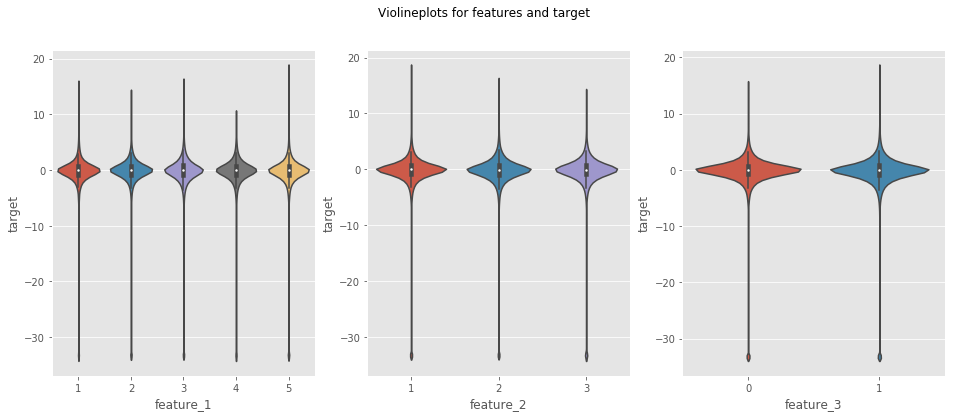

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1');
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2');
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3');

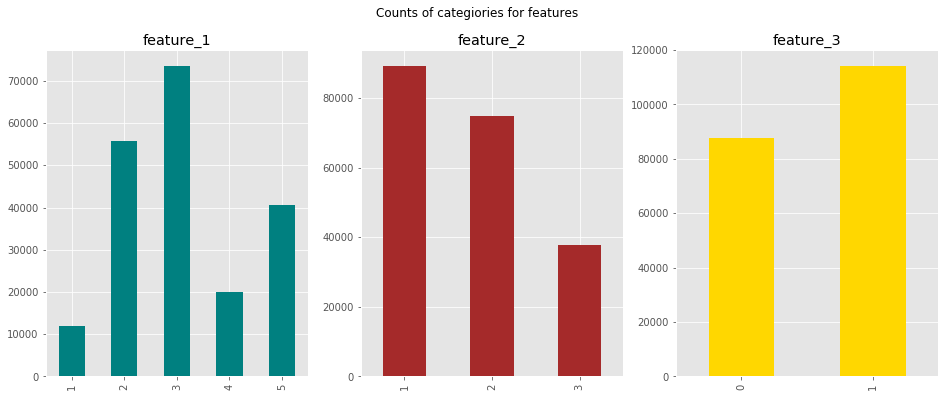

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('Counts of categiories for features');

These two plots show an important idea: while different categories of these features could have various counts, the distribution of target is almost the same. This could mean, that these features aren't really good at predicting target - we'll need other features and feature engineering.
Also it is worth noticing that mean target values of each catogory of these features is near zero. This could mean that data was sampled from normal distribution.

In [14]:
test['feature_1'] = test['feature_1'].astype('category')
test['feature_2'] = test['feature_2'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')

### date

In [15]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of first active",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

Trends of counts for train and test data are similar, and this is great.
Why there is such a sharp decline at the end of the period? I think it was on purpose. Or maybe new cards are taken into account only after fulfilling some conditions. 

Also there is one line with a missing data in test. I'll fill in with the first data, having the same values of features.

In [16]:
test.loc[test['first_active_month'].isna(), 'first_active_month'] = test.loc[(test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1), 'first_active_month'].min()

### target

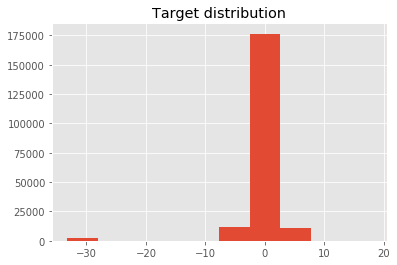

In [17]:
plt.hist(train['target']);
plt.title('Target distribution');

This looks really strange!

In [ ]:
print('There are {0} samples with target lower than -20.'.format(train.loc[train.target < -20].shape[0]))

And they have 1 unique value: -33.21928095.
This seems to be a special case. Maybe it would be reasonable to simply exclude these samples. We'll try later.

### Feature engineering

In [18]:
max_date = train['first_active_month'].dt.date.max()
def process_main(df):
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [19]:
train = process_main(train)
test = process_main(test)

## historical_transactions
Up to 3 months' worth of historical transactions for each card_id

In [20]:
historical_transactions = pd.read_csv('./input/historical_transactions.csv')
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [33]:
print('{} samples in data'.format(historical_transactions.shape[0]))
historical_transactions.head()

29112361 samples in data


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [34]:
# let's convert the authorized_flag to a binary value.
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

At average 91.35450058482031 transactions are authorized


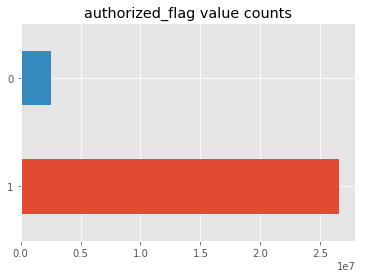

In [38]:
print("At average {} transactions are authorized".format(historical_transactions['authorized_flag'].mean() * 100))
historical_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

#### Cards with lowest and highest percentage of authorized transactions

In [39]:
autorized_card_rate = historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

In [40]:
autorized_card_rate.tail()

card_id
C_ID_d048b7cc60    1.0
C_ID_4e45fcdb43    1.0
C_ID_9f3ee1305e    1.0
C_ID_1b52a3e21b    1.0
C_ID_d3c3d988d5    1.0
Name: authorized_flag, dtype: float64

It seems that there are some cards, for which most of transactions were declined. Were this fraud transactions?

### installments

In [41]:
historical_transactions['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

Interesting. Most common number of installments are 0 and 1 which is expected. But -1 and 999 are strange. I think that these values were used to fill in missing values.

In [42]:
historical_transactions.groupby(['installments'])['authorized_flag'].mean()

installments
-1      0.885692
 0      0.928032
 1      0.907024
 2      0.884020
 3      0.862254
 4      0.819903
 5      0.809183
 6      0.779732
 7      0.693196
 8      0.692439
 9      0.663721
 10     0.702021
 11     0.660241
 12     0.653694
 999    0.031915
Name: authorized_flag, dtype: float64

On the other hand it seems that `999` could mean fraud transactions, considering only 3% of these transactions were approved. One more interesting thing is that the higher the number of installments is, the lower is the approval rate.

In [43]:
historical_transactions['installments'] = historical_transactions['installments'].astype('category')

In [44]:
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])

### purchase_amount
Sadly purchase_amount is normalized. Let's have a look at it nevertheless.

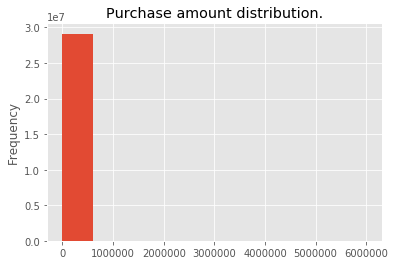

In [45]:
plt.title('Purchase amount distribution.');
historical_transactions['purchase_amount'].plot(kind='hist');

In [46]:
for i in [-1, 0]:
    n = historical_transactions.loc[historical_transactions['purchase_amount'] < i].shape[0]
    print("There are {} transactions with purchase_amount less than {}.".format(n, i))
for i in [0, 10, 100]:
    n = historical_transactions.loc[historical_transactions['purchase_amount'] > i].shape[0]
    print("There are {} transactions with purchase_amount more than {}.".format(n, i))

There are 0 transactions with purchase_amount less than -1.
There are 28036884 transactions with purchase_amount less than 0.
There are 1075467 transactions with purchase_amount more than 0.
There are 14924 transactions with purchase_amount more than 10.
There are 1183 transactions with purchase_amount more than 100.


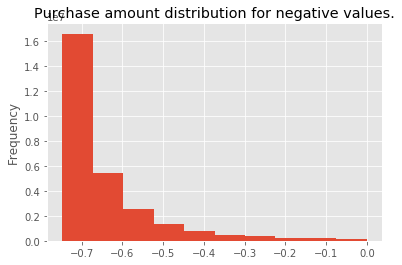

In [47]:
plt.title('Purchase amount distribution for negative values.');
historical_transactions.loc[historical_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

It seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers, which will need to be processed.

### Categories

In [48]:
map_dict = {'Y': 0, 'N': 1}
historical_transactions['category_1'] = historical_transactions['category_1'].apply(lambda x: map_dict[x])
historical_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_1                                                                 
0                 0.748578  0.433830       -0.419327    22.087594   2084029
1                 0.926265  0.261339        0.071540  1166.016045  27028332

In [49]:
historical_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_2                                                                 
1.0               0.927505  0.259306        0.149570  1548.714128  15177199
2.0               0.906225  0.291515       -0.165690    89.285770   1026535
3.0               0.918857  0.273055        0.180375   210.616100   3911795
4.0               0.927634  0.259094       -0.158951   141.945606   2618053
5.0               0.934260  0.247826       -0.104457   162.428785   3725915

In [50]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
historical_transactions['category_3'] = historical_transactions['category_3'].apply(lambda x: map_dict[str(x)])
historical_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_3                                                                 
0                 0.928032  0.258436        0.361926  1541.485188  15411747
1                 0.907024  0.290399       -0.404556   104.062692  11677522
2                 0.836498  0.369824        0.106023    24.047655   1844933
3                 0.885692  0.318186        0.058447     2.191567    178159

All categories are quite different

In [52]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print("There are {} unique values in {}.".format(historical_transactions[col].nunique(), col))

There are 308 unique values in city_id.
There are 327 unique values in merchant_category_id.
There are 326311 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


### Feature engineering

In [53]:
def aggregate_historical_transactions(trans, prefix):
    # more features from this kernel: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans['installments'] = trans['installments'].astype(int)

    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']). \
                                        astype(np.int64) * 1e-9
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
        'month_diff': ['min', 'max', 'mean']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [54]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group = aggregate_per_month(historical_transactions) 

In [55]:
%%time
del d1, d2, autorized_card_rate
gc.collect()
historical_transactions = reduce_mem_usage(historical_transactions)
history = aggregate_historical_transactions(historical_transactions, prefix='hist_')
history = reduce_mem_usage(history)
gc.collect()

Mem. usage decreased to 1166.08 Mb (62.5% reduction)
Mem. usage decreased to 35.39 Mb (68.2% reduction)
CPU times: user 5min 46s, sys: 20.1 s, total: 6min 6s
Wall time: 6min 8s


In [56]:
train = pd.merge(train, history, on = 'card_id', how ='left')
test = pd.merge(test, history, on = 'card_id', how='left')
del history

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [59]:
# del historical_transactions
gc.collect()

0

## new_merchant_transactions 
Two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

In [60]:
new_merchant_transactions = pd.read_csv('./input/new_merchant_transactions.csv')
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='new_merchant_period')
e

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [ ]:
print(f'{new_merchant_transactions.shape[0]} samples in data')
new_merchant_transactions.head()

In [61]:
# let's convert the authorized_flag to a binary value.
new_merchant_transactions['authorized_flag'] = new_merchant_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
print(f"At average {new_merchant_transactions['authorized_flag'].mean() * 100:.4f}% transactions are authorized")
new_merchant_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

In contrast with historical data, **all** transactions here were authorized!

#### Cards with lowest and highest total purchase amount

In [62]:
card_total_purchase = new_merchant_transactions.groupby(['card_id'])['purchase_amount'].sum().sort_values()
card_total_purchase.head()

card_id
C_ID_b7ebee6539   -70.813489
C_ID_8946508722   -63.907274
C_ID_c729288535   -61.042650
C_ID_6cef1dba4b   -60.780407
C_ID_0e4f6af077   -60.017000
Name: purchase_amount, dtype: float64

In [63]:
card_total_purchase.tail()

card_id
C_ID_72613043cf    109.086210
C_ID_01314ceccf    113.317420
C_ID_a9435eee72    145.168997
C_ID_a289e7edd4    172.182653
C_ID_ca850ecf25    263.157498
Name: purchase_amount, dtype: float64

It seems that there are some cards, for which most of transactions were declined. Were this fraud transactions?

### installments

In [64]:
new_merchant_transactions['installments'].value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

Interesting. Most common number of installments are 0 and 1 which is expected. But -1 and 999 are strange. I think that these values were used to fill in missing values.

In [65]:
new_merchant_transactions.groupby(['installments'])['purchase_amount'].sum()

installments
-1        1903.176718
 0     -581948.746520
 1     -507130.345871
 2      -21592.186709
 3       -6669.938153
 4        3212.909351
 5        2641.835005
 6        6994.802878
 7         522.470989
 8        1927.359352
 9         958.387496
 10      13864.551233
 11        117.734959
 12       3627.758765
 999         1.005048
Name: purchase_amount, dtype: float64

In [66]:
new_merchant_transactions['installments'] = new_merchant_transactions['installments'].astype('category')

### purchase_amount
Sadly purchase_amount is normalized. Let's have a look at it nevertheless.

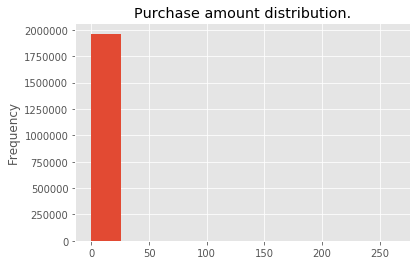

In [67]:
plt.title('Purchase amount distribution.');
new_merchant_transactions['purchase_amount'].plot(kind='hist');

In [70]:
for i in [-1, 0]:
    n = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < i].shape[0]
#     print(f"There are {n} transactions with purchase_amount less than {i}.")
for i in [0, 10, 100]:
    n = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] > i].shape[0]
#     print(f"There are {n} transactions with purchase_amount more than {i}.")

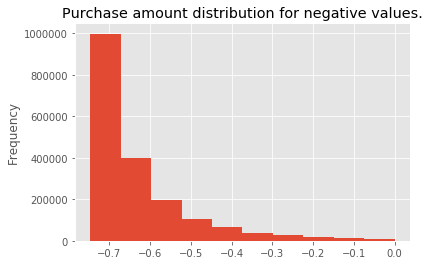

In [69]:
plt.title('Purchase amount distribution for negative values.');
new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

It seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers, which will need to be processed.

### Categories

In [71]:
map_dict = {'Y': 0, 'N': 1}
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1'].apply(lambda x: map_dict[x])
new_merchant_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_1                                   
0                -0.218671  1.481696    63096
1                -0.562004  0.648799  1899935

In [72]:
new_merchant_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_2                                   
1.0              -0.569242  0.673693  1058242
2.0              -0.555640  0.542029    65663
3.0              -0.550852  0.612882   289525
4.0              -0.557578  0.600636   178590
5.0              -0.549015  0.654138   259266

In [73]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].apply(lambda x: map_dict[str(x)])
new_merchant_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                  
                      mean       std   count
category_3                                  
0                -0.631014  0.268039  922244
1                -0.606486  0.443664  836178
2                 0.037708  1.787946  148687
3                 0.034033  1.692377   55922

All categories are quite different

In [74]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print(f"There are {new_merchant_transactions[col].nunique()} unique values in {col}.")

SyntaxError: invalid syntax (<ipython-input-74-875da52c8493>, line 2)

In [75]:
new_merchant_transactions['purchase_date'] = pd.to_datetime(new_merchant_transactions['purchase_date'])

### Feature engineering

In [76]:
def aggregate_historical_transactions(trans, prefix):
    # more features from this kernel: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['year'] = trans['purchase_date'].dt.year
    trans['weekofyear'] = trans['purchase_date'].dt.weekofyear
    trans['month'] = trans['purchase_date'].dt.month
    trans['dayofweek'] = trans['purchase_date'].dt.dayofweek
    trans['weekend'] = (trans.purchase_date.dt.weekday >=5).astype(int)
    trans['hour'] = trans['purchase_date'].dt.hour
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']

    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [77]:
%%time
gc.collect()
new_transactions = reduce_mem_usage(new_merchant_transactions)
history = aggregate_historical_transactions(new_merchant_transactions, prefix='new')
history = reduce_mem_usage(history)
del new_merchant_transactions
gc.collect()
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')
del history
gc.collect()

Mem. usage decreased to 73.01 Mb (62.9% reduction)
Mem. usage decreased to 24.34 Mb (65.2% reduction)


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

CPU times: user 56.6 s, sys: 1.61 s, total: 58.2 s
Wall time: 58.4 s


Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [78]:
train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')
gc.collect()
del final_group

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


## merchants
Aggregate information for each merchant_id

In [ ]:
merchants = pd.read_csv('../input/merchants.csv')
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='merchant')
e

In [ ]:
print(f'{merchants.shape[0]} merchants in data')
merchants.head()

In [ ]:
# encoding categories.
map_dict = {'Y': 0, 'N': 1}
merchants['category_1'] = merchants['category_1'].apply(lambda x: map_dict[x])
merchants.loc[merchants['category_2'].isnull(), 'category_2'] = 0
merchants['category_4'] = merchants['category_4'].apply(lambda x: map_dict[x])

In [ ]:
merchants['merchant_category_id'].nunique(), merchants['merchant_group_id'].nunique()

### numerical_1

In [ ]:
plt.hist(merchants['numerical_1']);
plt.title('Distribution of numerical_1');

In [ ]:
np.percentile(merchants['numerical_1'], 95)

Well, 95% of values are less than 0.1, we'll need to deal with outliers.

In [ ]:
plt.hist(merchants.loc[merchants['numerical_1'] < 0.1, 'numerical_1']);
plt.title('Distribution of numerical_1 less than 0.1');

In [ ]:
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

In fact more than a half values are equal to minimum value. A very skewered distribution.

### Numerical_2

In [ ]:
plt.hist(merchants['numerical_2']);
plt.title('Distribution of numerical_2');

In [ ]:
plt.hist(merchants.loc[merchants['numerical_2'] < 0.1, 'numerical_2']);
plt.title('Distribution of numerical_2 less than 0.1');
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print(f'{_ * 100:.4f}% of values in numerical_1 are equal to {min_n1}')

In [ ]:
(merchants['numerical_1'] != merchants['numerical_2']).sum() / merchants.shape[0]

These two variables are very similar. In fact for 90% merchants they are the same.

> most_recent_sales_range 	most_recent_purchases_range 	avg_sales_lag3 	avg_purchases_lag3 	active_months_lag3 	avg_sales_lag6 	avg_purchases_lag6 	active_months_lag6 	avg_sales_lag12 	avg_purchases_lag12 	active_months_lag12

### most_recent_sales_range

In [ ]:
merchants['most_recent_sales_range'].value_counts().plot('bar');

In [ ]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_sales_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_sales_range",
                        xaxis = dict(title = 'most_recent_sales_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

We can see that these ranges have different counts and different mean value of numerical_1 even after removing outliers.

### most_recent_purchases_range

In [ ]:
d = merchants['most_recent_purchases_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_purchases_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_purchases_range",
                        xaxis = dict(title = 'most_recent_purchases_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

These two variables seem to be quite similar.

### avg_sales_lag

In [ ]:
plt.hist(merchants['avg_sales_lag3'].fillna(0));
plt.hist(merchants['avg_sales_lag6'].fillna(0));
plt.hist(merchants['avg_sales_lag12'].fillna(0));

In [ ]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print(f'Max value of {col} is {merchants[col].max()}')
    print(f'Min value of {col} is {merchants[col].min()}')

In [ ]:
plt.hist(merchants.loc[(merchants['avg_sales_lag12'] < 3) & (merchants['avg_sales_lag12'] > -10), 'avg_sales_lag12'].fillna(0), label='avg_sales_lag12');
plt.hist(merchants.loc[(merchants['avg_sales_lag6'] < 3) & (merchants['avg_sales_lag6'] > -10), 'avg_sales_lag6'].fillna(0), label='avg_sales_lag6');
plt.hist(merchants.loc[(merchants['avg_sales_lag3'] < 3) & (merchants['avg_sales_lag3'] > -10), 'avg_sales_lag3'].fillna(0), label='avg_sales_lag3');
plt.legend();

Distribution of these values is quite similar and most values are between 0 and 2.

### avg_purchases_lag

In [ ]:
merchants['avg_purchases_lag3'].nlargest()

We even have infinite values...

In [ ]:
merchants.loc[merchants['avg_purchases_lag3'] == np.inf, 'avg_purchases_lag3'] = 6000
merchants.loc[merchants['avg_purchases_lag6'] == np.inf, 'avg_purchases_lag6'] = 6000
merchants.loc[merchants['avg_purchases_lag12'] == np.inf, 'avg_purchases_lag12'] = 6000

In [ ]:
plt.hist(merchants['avg_purchases_lag3'].fillna(0));
plt.hist(merchants['avg_purchases_lag6'].fillna(0));
plt.hist(merchants['avg_purchases_lag12'].fillna(0));

In [ ]:
plt.hist(merchants.loc[(merchants['avg_purchases_lag12'] < 4), 'avg_purchases_lag12'].fillna(0), label='avg_purchases_lag12');
plt.hist(merchants.loc[(merchants['avg_purchases_lag6'] < 4), 'avg_purchases_lag6'].fillna(0), label='avg_purchases_lag6');
plt.hist(merchants.loc[(merchants['avg_purchases_lag3'] < 4), 'avg_purchases_lag3'].fillna(0), label='avg_purchases_lag3');
plt.legend();

For now I won't use merchants data in models.

### Processing data for modelling

In [79]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_subsector_id_nunique,hist_city_id_nunique,hist_month_diff_min,hist_month_diff_max,hist_month_diff_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_3_3_sum,hist_category_3_3_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_merchant_category_id_nunique,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_month_lag_min,hist_month_lag_max,hist_category_3_2_sum,hist_category_3_2_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_merchant_id_nunique,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_state_id_nunique,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_3_1_sum,hist_category_3_1_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,newtransactions_count,newsubsector_id_nunique,newcity_id_nunique,newcategory_1_sum,newcategory_1_mean,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_3_3_sum,newcategory_3_3_mean,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newmerchant_category_id_nunique,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newmonth_lag_min,newmonth_lag_max,newcategory_3_2_sum,newcategory_3_2_mean,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newmerchant_id_nunique,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newstate_id_nunique,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newcategory_3_1_sum,newcategory_3_1_mean,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,month_lag_mean,month_lag_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,3,6,245,260,21,7,9,11,10.000000,260.0,1.000000,0.000000,0.0,0,0.000000,0.988281,257.0,41,8.054688,12,1,3.474609,-8,0,0.0,0.000000,4,0.015381,1,0,0.123291,20977988.0,1.519551e+09,1.498573e+09,0.0,0.0,94,0.011536,3.0,3,0.0,0.0,247.0,0.950195,4.0,0.015381,-165.968735,-0.638341,2.258394,-0.739258,0.212139,23.0,10.0,3.0,23.0,1.000000,0.000000,0.0,0.0,0.000000,1.000000,23.0,14.0,3.478516,4.0,3.0,0.510742,1.0,2.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,4742309.0,1.525001e+09,1.520259e+09,0.000000,0.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,-4.000000,2.738613,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,6,1,396,350,24,9,10,12,11.054688,319.0,0.911621,0.000000,0.0,2,0.005714,0.911621,319.0,57,6.218750,12,1,3.847656,-12,0,72.0,0.205688,543,1.551758,10,-1,1.510742,33717688.0,1.517438e+09,1.483720e+09,0.0,0.0,142,0.000000,0.0,3,0.0,0.0,339.0,0.968750,276.0,0.788574,-2

In [80]:
for col in train.columns:
    if train[col].isna().any():
        train[col] = train[col].fillna(0)

In [81]:
for col in test.columns:
    if test[col].isna().any():
        test[col] = test[col].fillna(0)

In [82]:
y = train['target']

In [83]:
col_to_drop = ['first_active_month', 'card_id', 'target']

In [84]:
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [85]:
train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)

In [86]:
categorical_feats = ['feature_1', 'feature_2']

for col in categorical_feats:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [89]:
train.head()

,feature_1,feature_2,feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_subsector_id_nunique,hist_city_id_nunique,hist_month_diff_min,hist_month_diff_max,hist_month_diff_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_3_3_sum,hist_category_3_3_mean,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_merchant_category_id_nunique,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_month_lag_min,hist_month_lag_max,hist_category_3_2_sum,hist_category_3_2_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_merchant_id_nunique,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_state_id_nunique,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_3_1_sum,hist_category_3_1_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,newtransactions_count,newsubsector_id_nunique,newcity_id_nunique,newcategory_1_sum,newcategory_1_mean,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_3_3_sum,newcategory_3_3_mean,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newmerchant_category_id_nunique,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newmonth_lag_min,newmonth_lag_max,newcategory_3_2_sum,newcategory_3_2_mean,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newmerchant_id_nunique,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newstate_id_nunique,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newcategory_3_1_sum,newcategory_3_1_mean,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,month_lag_mean,month_lag_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,newpurchase_amount_max_to_mean,newpurchase_date_max_to_mean,purchase_amount_max_mean_to_mean
0,4,1,1,2017,3,6,245,260,21,7,9,11,10.000000,260.0,1.000000,0.000000,0.0,0,0.000000,0.988281,257.0,41,8.054688,12,1,3.474609,-8,0,0.0,0.000000,4,0.015381,1,0,0.123291,20977988.0,1.519551e+09,1.498573e+09,0.0,0.0,94,0.011536,3.0,3,0.0,0.0,247.0,0.950195,4.0,0.015381,-165.968735,-0.638341,2.258394,-0.739258,0.212139,23.0,10.0,3.0,23.0,1.000000,0.000000,0.0,0.0,0.000000,1.000000,23.0,14.0,3.478516,4.0,3.0,0.510742,1.0,2.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,4742309.0,1.525001e+09,1.520259e+09,0.000000,0.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,-4.000000,2.738613,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152,inf,1.124967,-0.011048
1,3,0,0,2017,6,1,396,350,24,9,10,12,11.054688,319.0,0.911621,0.000000,0.0,2,0.005714,0.911621,319.0,57,6.218750,12,1,3.847656,-12,0,72.0,0.205688,543,1.551758,10,-1,1.510742,33717688.0,1.517438e+09,1.483720e+09,0.0,0.0,142,0.000000,0.0,3,0.0,0.0,339.0,0.968750,276.0,0.

In [88]:
for col in ['newpurchase_amount_max', 'newpurchase_date_max', 'purchase_amount_max_mean']:
    train[col + '_to_mean'] = train[col] / train[col].mean()
    test[col + '_to_mean'] = test[col] / test[col].mean()

### Basic LGB model

In [113]:
X = train
X_test = test

#### Code for training models

In [114]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [141]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgboost.DMatrix(data=X_train, label=y_train)
            valid_data = xgboost.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgboost.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgboost.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print('Fold {}. RMSE: {}.'.format(fold_n, score))
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [93]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 15,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}

Fold 0 started at Tue Dec 25 14:53:32 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's rmse: 3.39215	valid_1's rmse: 3.70993
Fold 1 started at Tue Dec 25 14:54:04 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[700]	training's rmse: 3.27499	valid_1's rmse: 3.63552
Fold 2 started at Tue Dec 25 14:54:59 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[654]	training's rmse: 3.28699	valid_1's rmse: 3.67822
Fold 3 started at Tue Dec 25 14:55:46 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[444]	training's rmse: 3.36459	valid_1's rmse: 3.66556
Fold 4 started at Tue Dec 25 14:56:22 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[641]	training's rmse: 3.29521	valid_1's rmse: 3.62062
CV mean score: 3.662

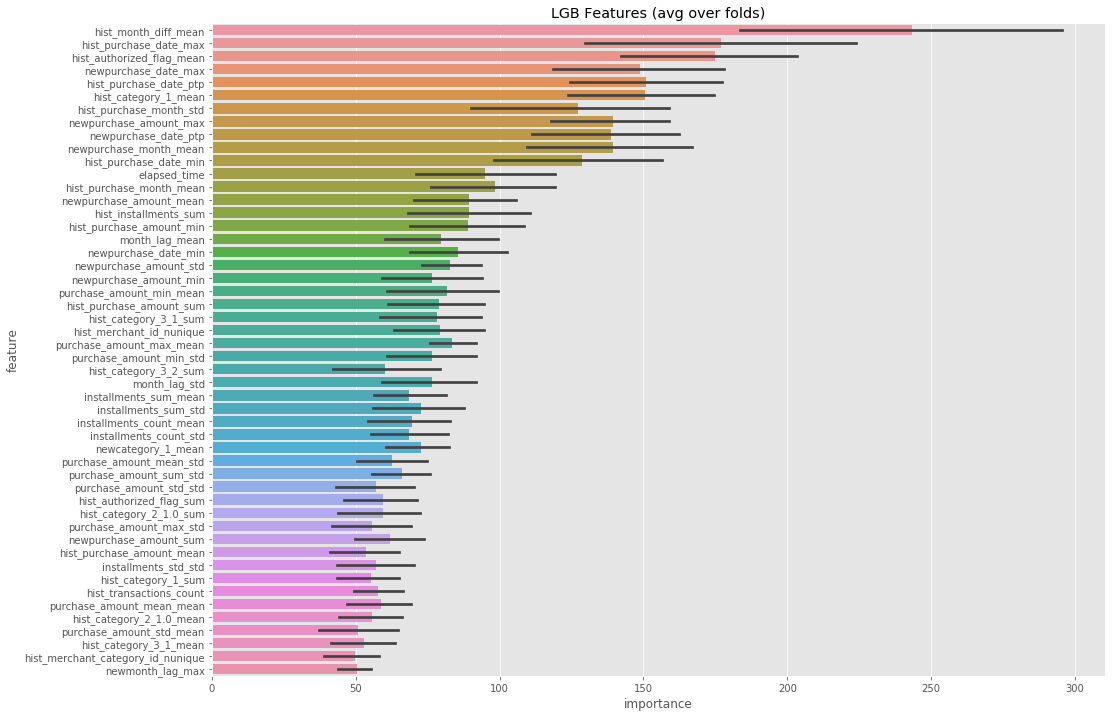

In [94]:
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [95]:
submission['target'] = prediction_lgb
submission.to_csv('./output/submission.csv', index = False)

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# Reference: code from Ashish Patel(阿希什)Repeated KFOLD Approach: RMSE[3.70]
# Kfold cross-validation
# folds = KFold(n_splits=5, shuffle=True, random_state=11)

nfolds = 5
nrepeats = 2 
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
fold_pred = np.zeros(len(train))
feature_importance_df = pd.DataFrame()
lgb_preds = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label= y.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(train.iloc[val_idx], label= y.iloc[val_idx]) #categorical_feature=categorical_feats

    iteration = 2000
    lgb_m = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    fold_pred[val_idx] = lgb_m.predict(train.iloc[val_idx], num_iteration=lgb_m.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = lgb_m.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    lgb_preds += lgb_m.predict(test, num_iteration=lgb_m.best_iteration) / (nfolds*nrepeats)

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, y))))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.57066	valid_1's rmse: 3.73572
[200]	training's rmse: 3.48115	valid_1's rmse: 3.71452
[300]	training's rmse: 3.42309	valid_1's rmse: 3.70886
[400]	training's rmse: 3.37562	valid_1's rmse: 3.70656
[500]	training's rmse: 3.33189	valid_1's rmse: 3.7061
[600]	training's rmse: 3.29477	valid_1's rmse: 3.70619
Early stopping, best iteration is:
[522]	training's rmse: 3.3236	valid_1's rmse: 3.70568
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.58874	valid_1's rmse: 3.6628
[200]	training's rmse: 3.50054	valid_1's rmse: 3.64549
[300]	training's rmse: 3.44288	valid_1's rmse: 3.64108
[400]	training's rmse: 3.3955	valid_1's rmse: 3.63896
[500]	training's rmse: 3.35377	valid_1's rmse: 3.63804
[600]	training's rmse: 3.31311	valid_1's rmse: 3.63763
[700]	training's rmse: 3.27689	valid_1's rmse: 3.63725
Early stopping, best iteration is:
[650]	training's rms

In [127]:
# Check feature correlation 
# important_features = list(final_importance['feature'][0:60])

# ranking all feature by avg importance score from Kfold, select top 100
all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:100]['feature'])
# all_features[0:100]
df = train[important_features]
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(high_cor))
print(high_cor)



# final selected features: drop highly correlated features from important features.
features = [i for i in important_features if i not in high_cor]
print(len(features))
print(features)

train = train[features]
test = test[features]

25
['hist_purchase_date_max', 'newpurchase_date_min', 'hist_purchase_amount_sum', 'month_lag_std', 'purchase_amount_min_std', 'purchase_amount_sum_std', 'purchase_amount_std_std', 'purchase_amount_mean_mean', 'purchase_amount_mean_std', 'purchase_amount_max_std', 'hist_authorized_flag_sum', 'hist_category_1_sum', 'purchase_amount_std_mean', 'hist_purchase_amount_mean', 'hist_month_diff_max', 'purchase_amount_sum_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_std', 'newpurchase_date_max_to_mean', 'hist_month_diff_min', 'newpurchase_month_max', 'newcategory_1_sum', 'purchase_amount_max_mean_to_mean', 'newmerchant_id_nunique', 'newsubsector_id_nunique']
75
['hist_month_diff_mean', 'hist_authorized_flag_mean', 'hist_category_1_mean', 'hist_purchase_date_ptp', 'newpurchase_date_max', 'newpurchase_amount_max', 'newpurchase_date_ptp', 'newpurchase_month_mean', 'hist_purchase_date_min', 'hist_purchase_month_std', 'elapsed_time', 'hist_purchase_month_mean', 'newpurchase_amount_mean', 

In [128]:
# Use Kfold predict
nfolds = 5
nrepeats = 2 

folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
fold_pred = np.zeros(len(train))
lgb_preds = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, y.values)): #target.values
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=y.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(train.iloc[val_idx], label=y.iloc[val_idx]) #categorical_feature=categorical_feats

    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    fold_pred[val_idx] = lgb_model.predict(train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    lgb_preds += lgb_model.predict(test, num_iteration=lgb_model.best_iteration) / (nfolds*nrepeats)

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, y))))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.5769	valid_1's rmse: 3.73683
[200]	training's rmse: 3.49121	valid_1's rmse: 3.71348
[300]	training's rmse: 3.43734	valid_1's rmse: 3.70638
[400]	training's rmse: 3.39333	valid_1's rmse: 3.7055
[500]	training's rmse: 3.35315	valid_1's rmse: 3.70558
Early stopping, best iteration is:
[471]	training's rmse: 3.36448	valid_1's rmse: 3.70449
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.59366	valid_1's rmse: 3.66525
[200]	training's rmse: 3.50837	valid_1's rmse: 3.64784
[300]	training's rmse: 3.45381	valid_1's rmse: 3.64298
[400]	training's rmse: 3.40954	valid_1's rmse: 3.64059
[500]	training's rmse: 3.37073	valid_1's rmse: 3.64118
Early stopping, best iteration is:
[412]	training's rmse: 3.40418	valid_1's rmse: 3.64031
fold n°2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.58436	valid_1's rmse: 3.71212
[

In [130]:
# Add target value to submition file
submission["target"] = lgb_preds
submission.to_csv("./output/lgb_submission.csv", index=False)

In [143]:
xgb_params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Tue Dec 25 15:56:56 2018


AttributeError: module 'xgboost' has no attribute 'DMatrix'

In [ ]:
submission['target'] = prediction_xgb
submission.to_csv('xgb.csv', index=False)

In [120]:
 train.columns[train.isna().any()].tolist()

[]

In [116]:
oof_rcv, prediction_rcv = train_model(params = None, model_type='rcv')

Fold 0 started at Tue Dec 25 15:15:24 2018
100.0
Fold 0. RMSE: 3.834153422699208.



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
submission['target'] = prediction_rcv
submission.to_csv('rcv.csv', index=False)

In [142]:
cat_params = {'learning_rate': 0.01,
              'depth': 12,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}

oof_cat, prediction_cat = train_model(params=cat_params, model_type='cat')

Fold 0 started at Tue Dec 25 15:56:30 2018


KeyboardInterrupt: 

In [ ]:
submission['target'] = (prediction_lgb + prediction_cat) / 2
submission.to_csv('blend.csv', index=False)

In [ ]:
train_stack = np.vstack([oof_lgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack)
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_rcv, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

In [ ]:
oof_lgb_stack, prediction_lgb_stack = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb')

In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = prediction_lgb_stack
sample_submission.to_csv('stacker_lgb.csv', index=False)

In [ ]:
oof_rcv_stack, prediction_rcv_stack = train_model(X=train_stack, X_test=test_stack, params=None, model_type='rcv')

In [ ]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = prediction_rcv_stack
sample_submission.to_csv('stacker_rcv.csv', index=False)